In [3]:
# Importar las librerias necesarias
from pydataxm import *
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tsfresh import extract_featurese
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import adfuller, kpss

In [4]:
objetoAPI = pydataxm.ReadDB()  # Se almacena el servicio de obtención de los datos en el nombre objetoAPI

In [ ]:
df_metrics = objetoAPI.get_collections() #El método get_collection sin argumentos retorna todas las variables que se tienen disponible en la API y que se pueden consultar  
list(df_metrics['MetricName'].sort_values()) # Encontramos la variable que nos interesa
# El cual se denomina 'Precio Bolsa Nacional por Sistema'

In [15]:
df_metrics[df_metrics['MetricName'] == 'Precio Bolsa Nacional por Sistema']

,MetricId,MetricName,Entity,MaxDays,Type,Url,Filter,MetricUnits,MetricDescription
6,PrecBolsNaci,Precio Bolsa Nacional por Sistema,Sistema,31,HourlyEntities,http://servapibi.xm.com.co/hourly,No aplica,COP/kWh,Precio de oferta de la última planta flexible ...


In [20]:
# Encontramos y describimos la metrica necesaria
Unidad = df_metrics[df_metrics['MetricName'] == 'Precio Bolsa Nacional por Sistema']['MetricUnits'].iloc[0]
Definicion = df_metrics[df_metrics['MetricName'] == 'Precio Bolsa Nacional por Sistema']['MetricDescription'].iloc[0]
Tipo = df_metrics[df_metrics['MetricName'] == 'Precio Bolsa Nacional por Sistema']['Type'].iloc[0]
print("La unidad es:", Unidad)
print("Su definicion es:", Definicion)
if Tipo == 'HourlyEntities':
    Tipo = 'Horario'
print("Es de tipo:", Tipo)

La unidad es: COP/kWh
Su definicion es: Precio de oferta de la última planta flexible para atender la demanda comercial nacional, más delta de incremento para remunerar los costos no cubiertos de las plantas térmicas en el despacho ideal.
Es de tipo: Horario


In [5]:
# Creamos una lista con todas las fechas que podemos obtener y obtenemos los datos por cada dia
start_date = datetime(2000, 1, 1)
end_date = datetime(2023, 5, 31)
    
dates = pd.date_range(start=start_date, end=end_date, freq='MS')
month_starts = dates.strftime('%Y-%m-%d')
month_ends = (dates + pd.offsets.MonthEnd(1) - timedelta(days=1)).strftime('%Y-%m-%d')

df_data = pd.DataFrame()

for start, end in zip(month_starts, month_ends):
    fecha_ini = datetime.strptime(start, '%Y-%m-%d').date()
    fecha_fin = datetime.strptime(end, '%Y-%m-%d').date()

    df_variable = objetoAPI.request_data(
                        "PrecBolsNaci",           # Se indica el nombre de la métrica tal como se llama en el campo metricId
                        "Sistema",               # Se indica el nombre de la entidad tal como se llama en el campo Entity
                        fecha_ini,     # Corresponde a la fecha inicial de la consulta (YYYY-MM-DD)
                        fecha_fin) 

    df_data = pd.concat([df_data, df_variable], ignore_index=True)

In [7]:
df_data = df_data.drop(["Values_code", "Id"], axis=1)  # Eliminar columnas no necesarias

In [23]:
# Convertirmos el dataframe de 24 columnas a un dataframe de 1 columna
data_dict = []
for i, row in df_data.iterrows():
    dates = pd.date_range(row['Date'], periods=24, freq='H')
    df_exam = pd.DataFrame(row.iloc[1:].values)
    df_exam['date_hour'] = dates
    df_exam = df_exam.set_index('date_hour')
    df_exam.columns = ['price']
    df_exam.iloc[-1] = df_exam.iloc[-2]
    data_dict.append(df_exam)

df_data_colum = pd.concat(data_dict)
df_data_colum.reset_index(inplace=True)

In [24]:
df_data_colum.head() # Muestra de los datos

,date_hour,price
0,2000-01-01 00:00:00,32.28479
1,2000-01-01 01:00:00,32.28479
2,2000-01-01 02:00:00,32.28479
3,2000-01-01 03:00:00,32.28479
4,2000-01-01 04:00:00,32.28479


In [25]:
# Convertir a fechas
df_data_colum['date_hour'] = pd.to_datetime(df_data_colum['date_hour'])

# Extraer hora
df_data_colum['hora'] = df_data_colum['date_hour'].dt.hour

# Extraer quarter
df_data_colum['quarter'] = df_data_colum['date_hour'].dt.quarter

# Extraer semana del año
df_data_colum['semana del año'] = [x.isocalendar()[1] for x in df_data_colum['date_hour']]

# Extraer mes
df_data_colum['mes'] = df_data_colum['date_hour'].dt.month

# Extraer año
df_data_colum['año'] = df_data_colum['date_hour'].dt.year

# Extraer dia
df_data_colum['dia'] = df_data_colum['date_hour'].dt.day

# Extraer dia de semana
df_data_colum['dia de semana'] = df_data_colum['date_hour'].dt.strftime('%A')

# Ordenar los dias de semana y traducir
dias_traducidos = {'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles', 'Thursday': 'Jueves',
                   'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'}
df_data_colum['dia de semana'] = pd.Categorical(df_data_colum['dia de semana'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df_data_colum = df_data_colum.sort_values(['date_hour','dia de semana'])
df_data_colum['dia de semana'] = df_data_colum['dia de semana'].map(dias_traducidos)

In [ ]:
df_data_colum = df_data_colum.set_index('date_hour') # Colocamos la fecha como indice

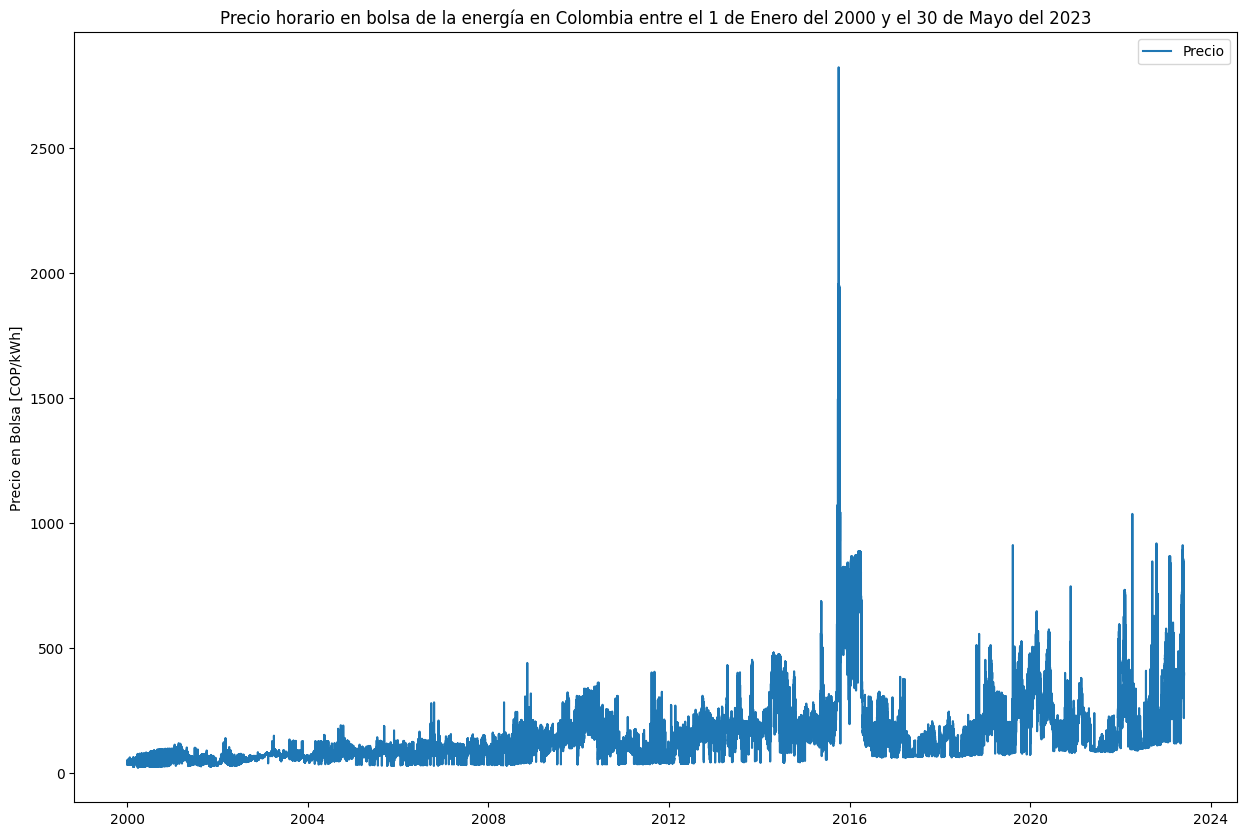

In [115]:
x = df_data_colum.index
y = df_data_colum['price']

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(x, y, label='Precio')

ax.set_ylabel('Precio en Bolsa [COP/kWh]')
ax.set_title('Precio horario en bolsa de la energía en Colombia entre el 1 de Enero del 2000 y el 30 de Mayo del 2023')
ax.legend()
plt.show()

In [14]:
df_resa_2 = df_data_colum['price'].resample('M').mean().dropna()

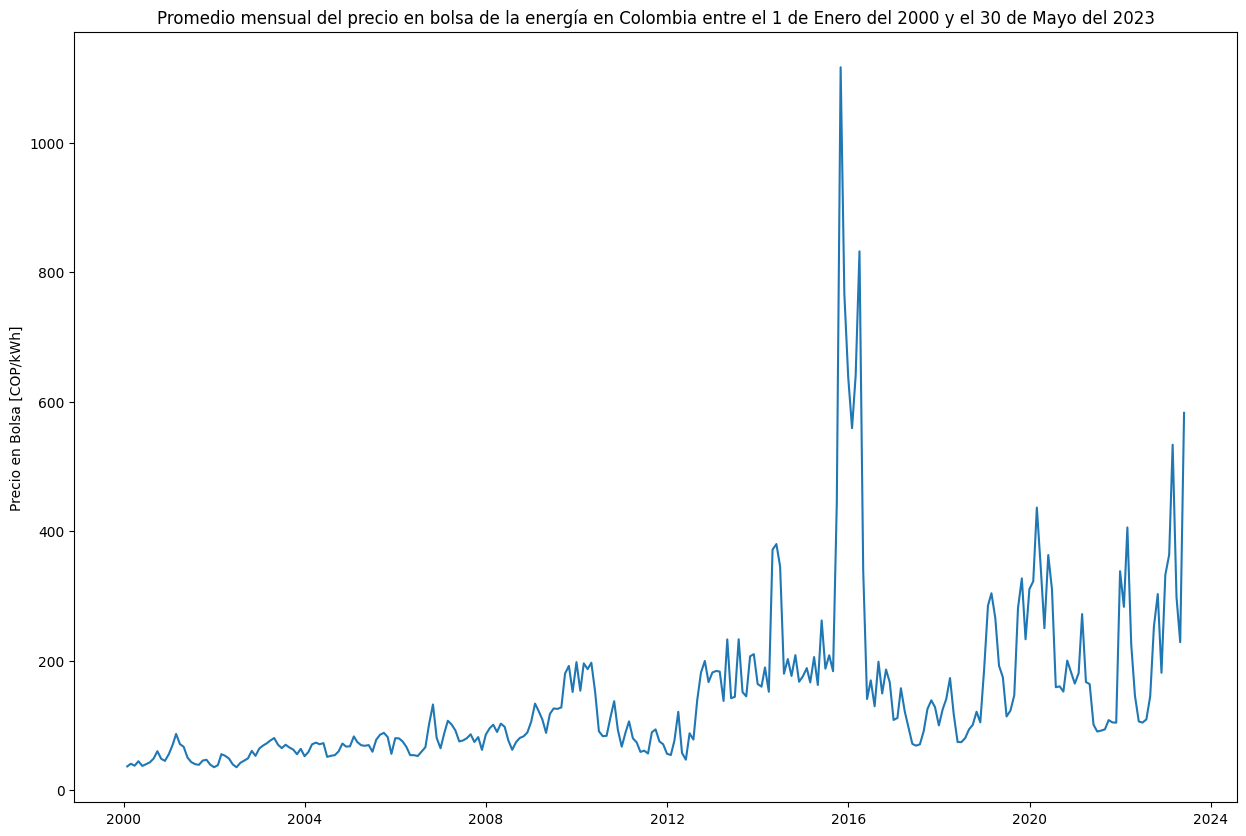

In [116]:

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df_resa_2.index, df_resa_2.values)

ax.set_ylabel('Precio en Bolsa [COP/kWh]')
ax.set_title('Promedio mensual del precio en bolsa de la energía en Colombia entre el 1 de Enero del 2000 y el 30 de Mayo del 2023')

plt.show()

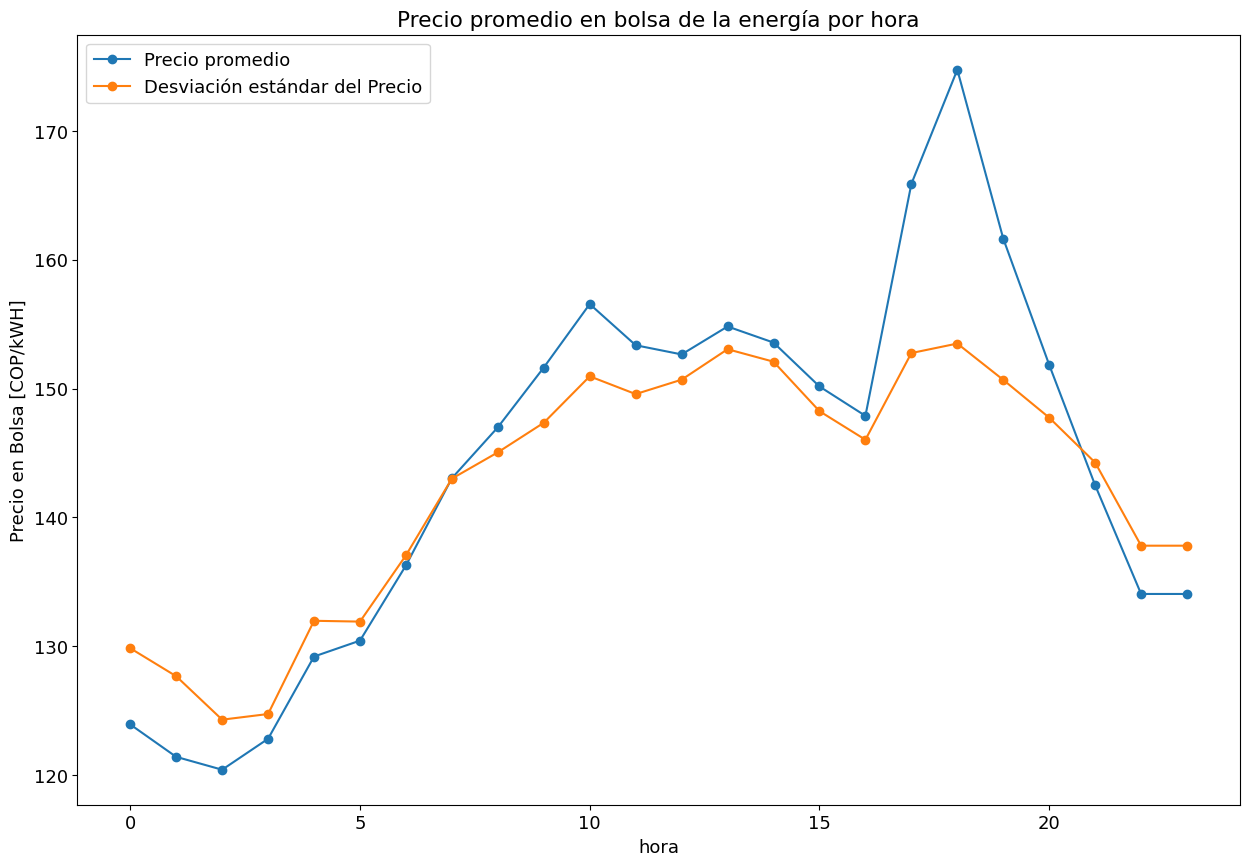

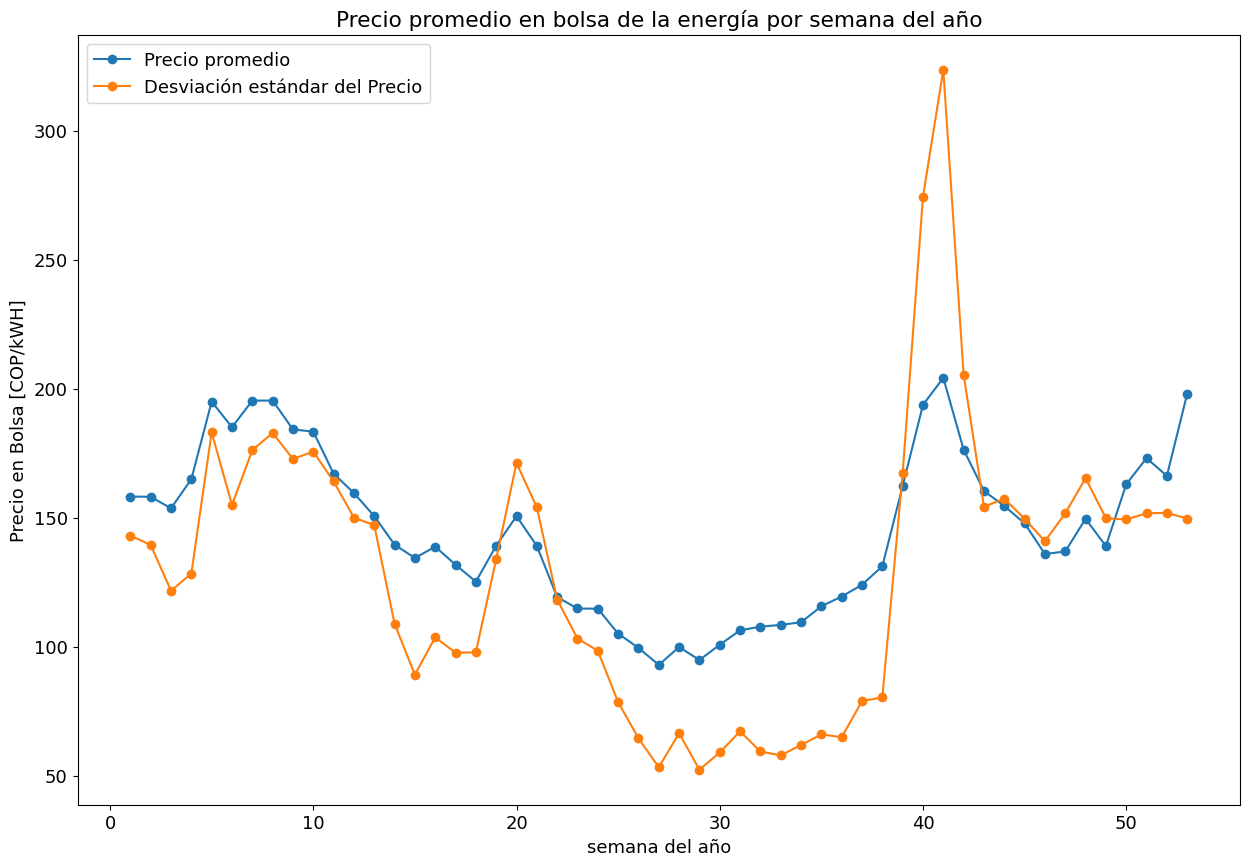

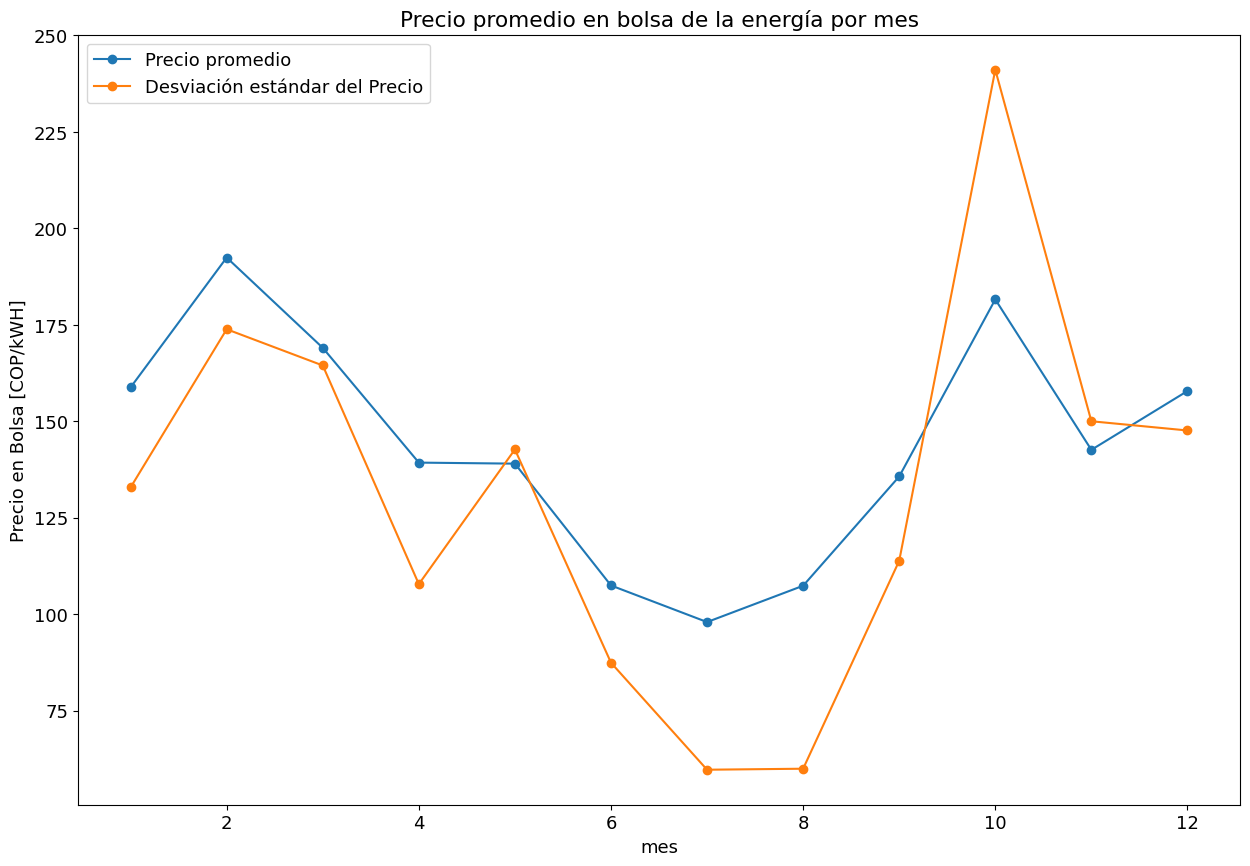

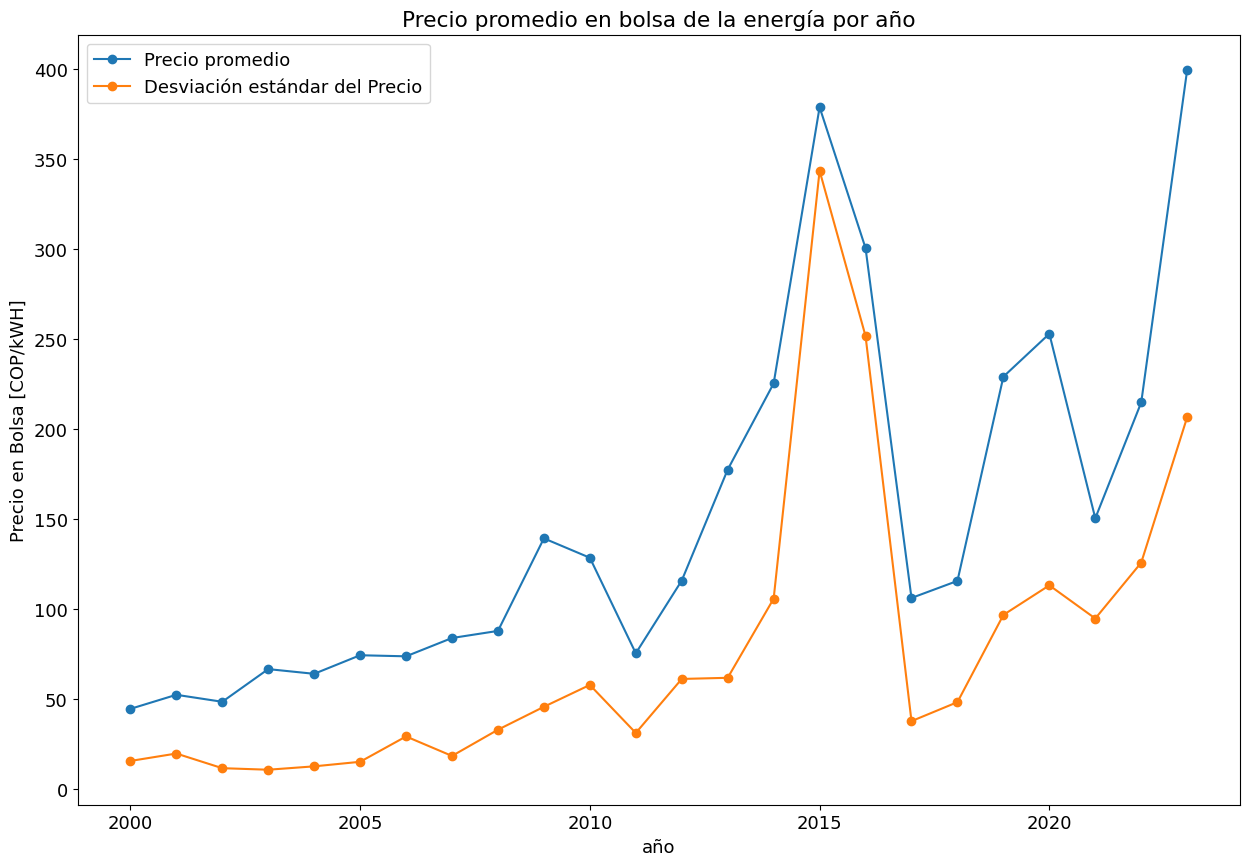

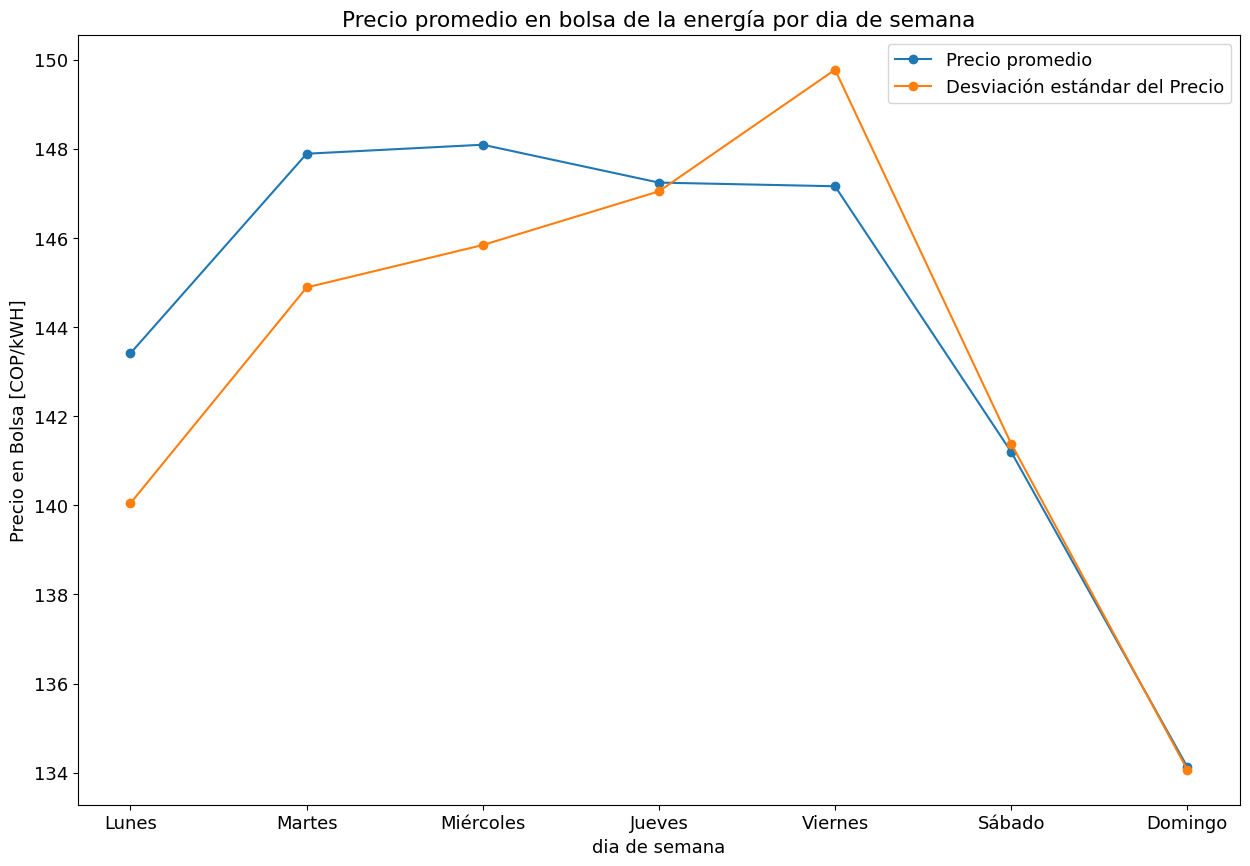

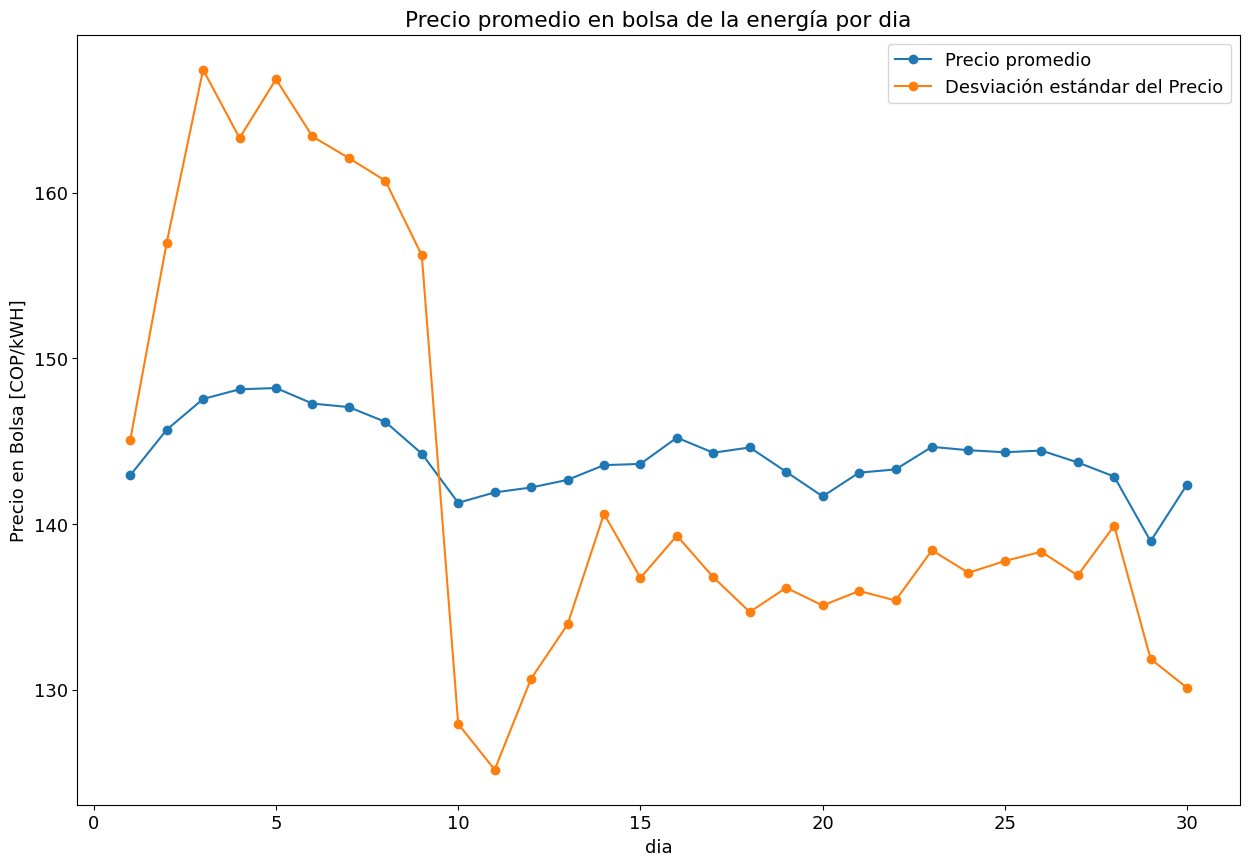

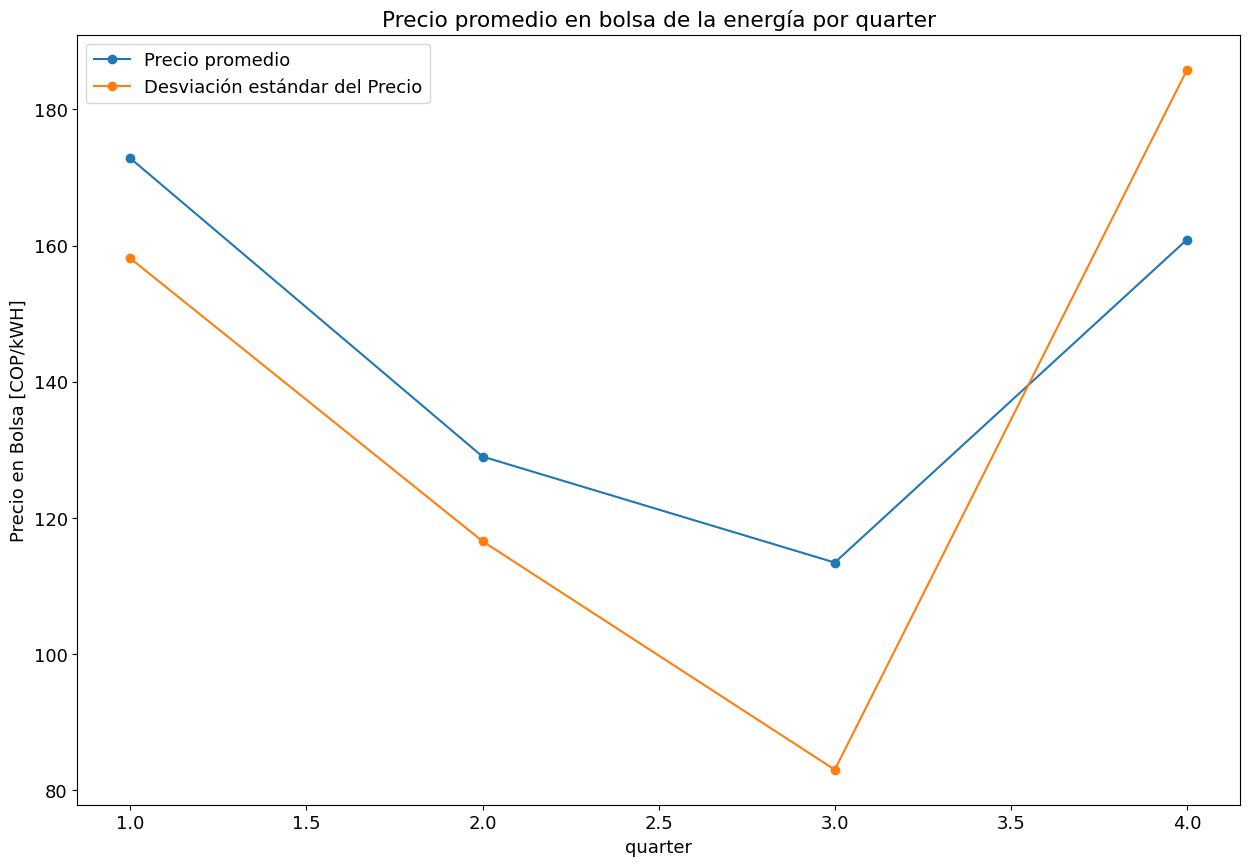

In [63]:
for vari in ['hora', 'semana del año', 'mes', 'año', 'dia de semana', 'dia', 'quarter']:
    x = df_data_colum.groupby(vari)[['price']].mean().index
    y = df_data_colum.groupby(vari)[['price']].mean().values
    std = df_data_colum.groupby(vari)[['price']].std().values

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(x, y, label='Precio promedio', marker='o', linestyle='-')
    ax.plot(x, std, label='Desviación estándar del Precio', marker='o', linestyle='-')

    ax.set_xlabel(vari)
    ax.set_ylabel('Precio en Bolsa [COP/kWH]')
    ax.set_title(f'Precio promedio en bolsa de la energía por {vari}')
    ax.legend()

    plt.show()


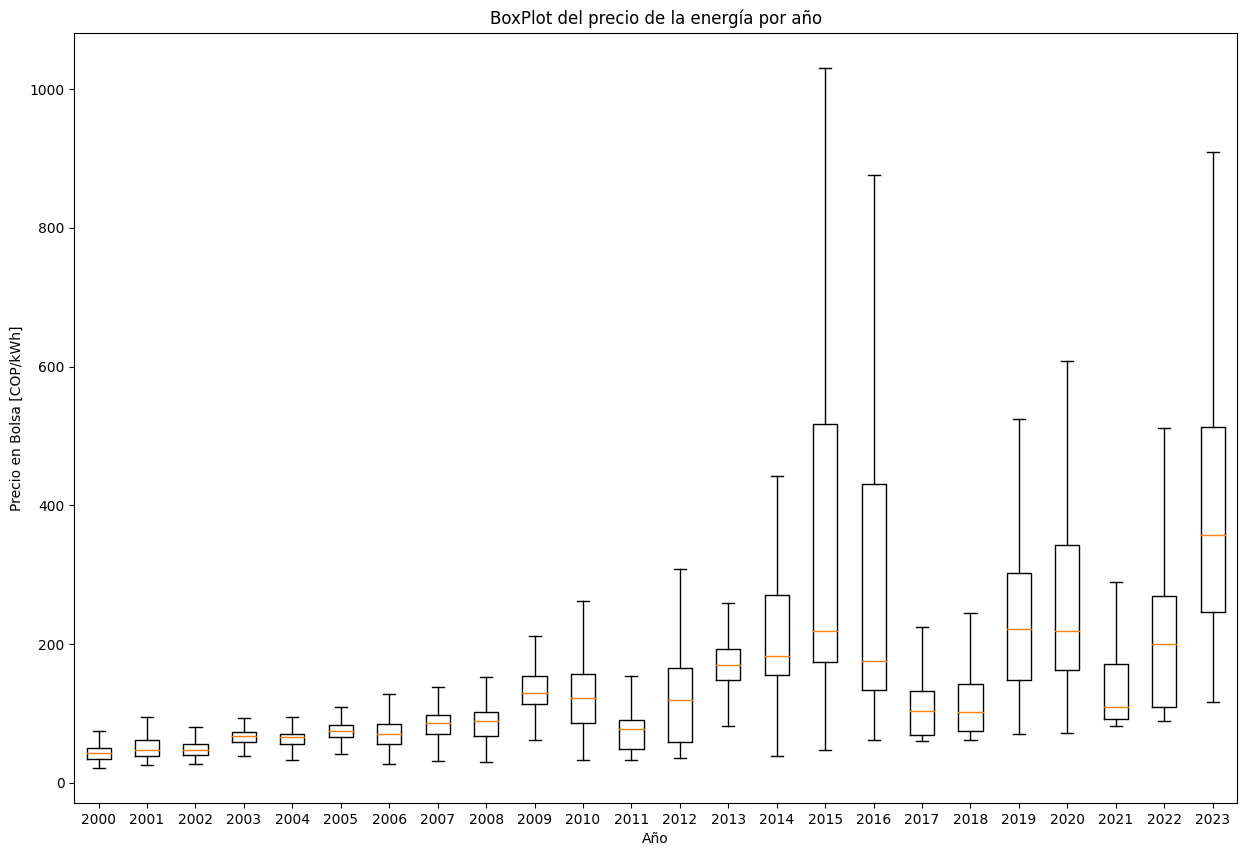

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
df_grouped = df_data_colum.groupby('año')['price'].apply(list).reset_index()
ax.boxplot(df_grouped['price'], labels=df_grouped['año'], showfliers=False)

ax.set_xlabel('Año')
ax.set_ylabel('Precio en Bolsa [COP/kWh]')
ax.set_title(f'BoxPlot del precio de la energía por año')

plt.show()

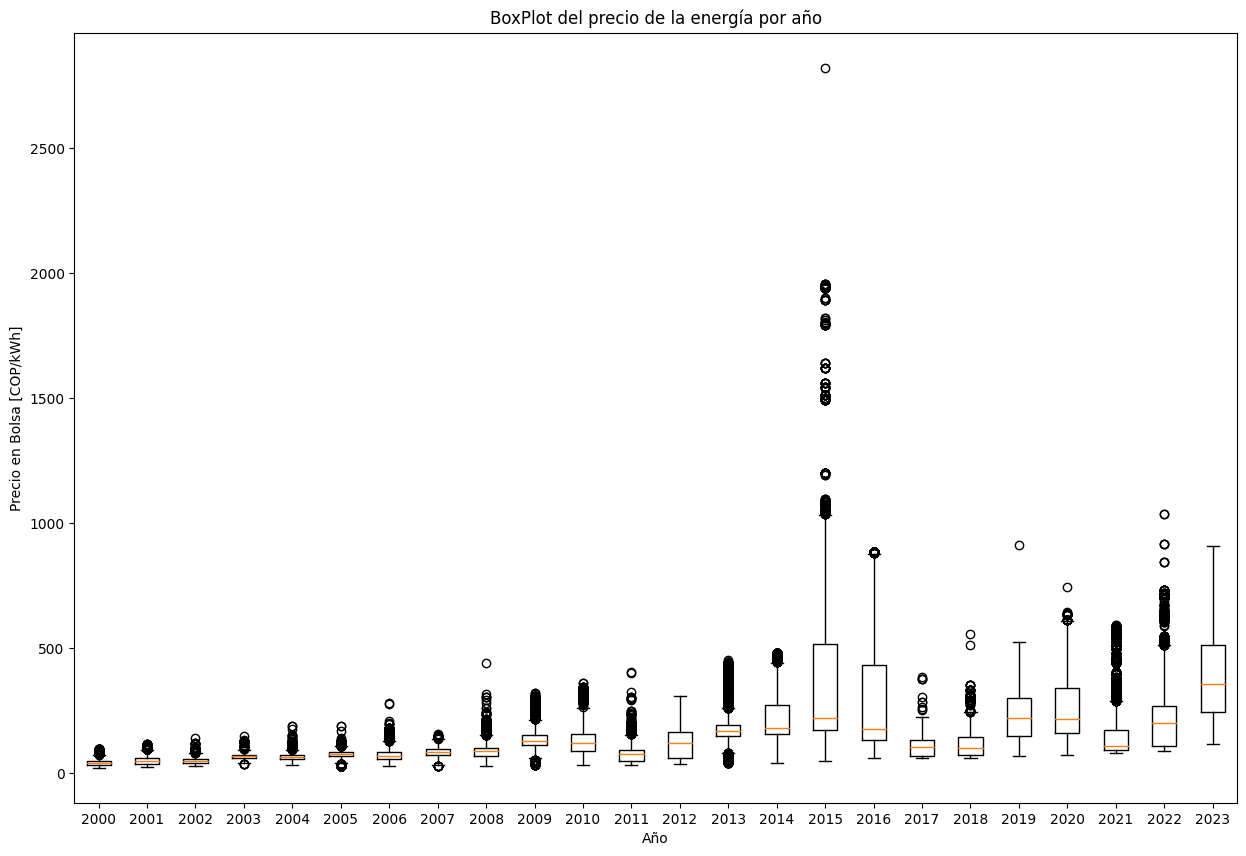

In [26]:
fig, ax = plt.subplots(figsize=(15, 10))
df_grouped = df_data_colum.groupby('año')['price'].apply(list).reset_index()
ax.boxplot(df_grouped['price'], labels=df_grouped['año'])

ax.set_xlabel('Año')
ax.set_ylabel('Precio en Bolsa [COP/kWh]')
ax.set_title(f'BoxPlot del precio de la energía por año')

plt.show()

Análisis de estacionalidad, tendencia y ruido

In [33]:
rcParams["figure.figsize"] = (15,10)

In [45]:
mstl = MSTL(df_resa_2, periods=(7, 30, 90, 365), stl_kwargs={"seasonal_deg": 0})
df_seasonal = mstl.fit() 

In [4]:
# Extraer dia de semana
df_seasonal['dia de semana'] = df_seasonal['date_hour'].dt.strftime('%A')

# Ordenar los dias de semana y traducir
dias_traducidos = {'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles', 'Thursday': 'Jueves',
                   'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'}
df_seasonal['dia de semana'] = pd.Categorical(df_seasonal['dia de semana'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df_seasonal = df_seasonal.sort_values(['date_hour','dia de semana'])
df_seasonal['dia de semana'] = df_seasonal['dia de semana'].map(dias_traducidos)

# Extraer dia del mes
df_seasonal['mes'] = df_seasonal['date_hour'].dt.strftime('%d')

# Extraer dia del año
df_seasonal['año'] = df_seasonal['date_hour'].dt.strftime('%B %d')

# Extraer dia del quarter
def obtener_dia_trimestre(fecha):
    trimestre = (fecha.month - 1) // 3 + 1
    primer_dia_trimestre = datetime(fecha.year, (trimestre - 1) * 3 + 1, 1)
    diferencia = fecha - primer_dia_trimestre
    dia_trimestre = diferencia.days + 1
    return dia_trimestre

df_seasonal['trimestral'] = df_seasonal['date_hour'].apply(obtener_dia_trimestre)

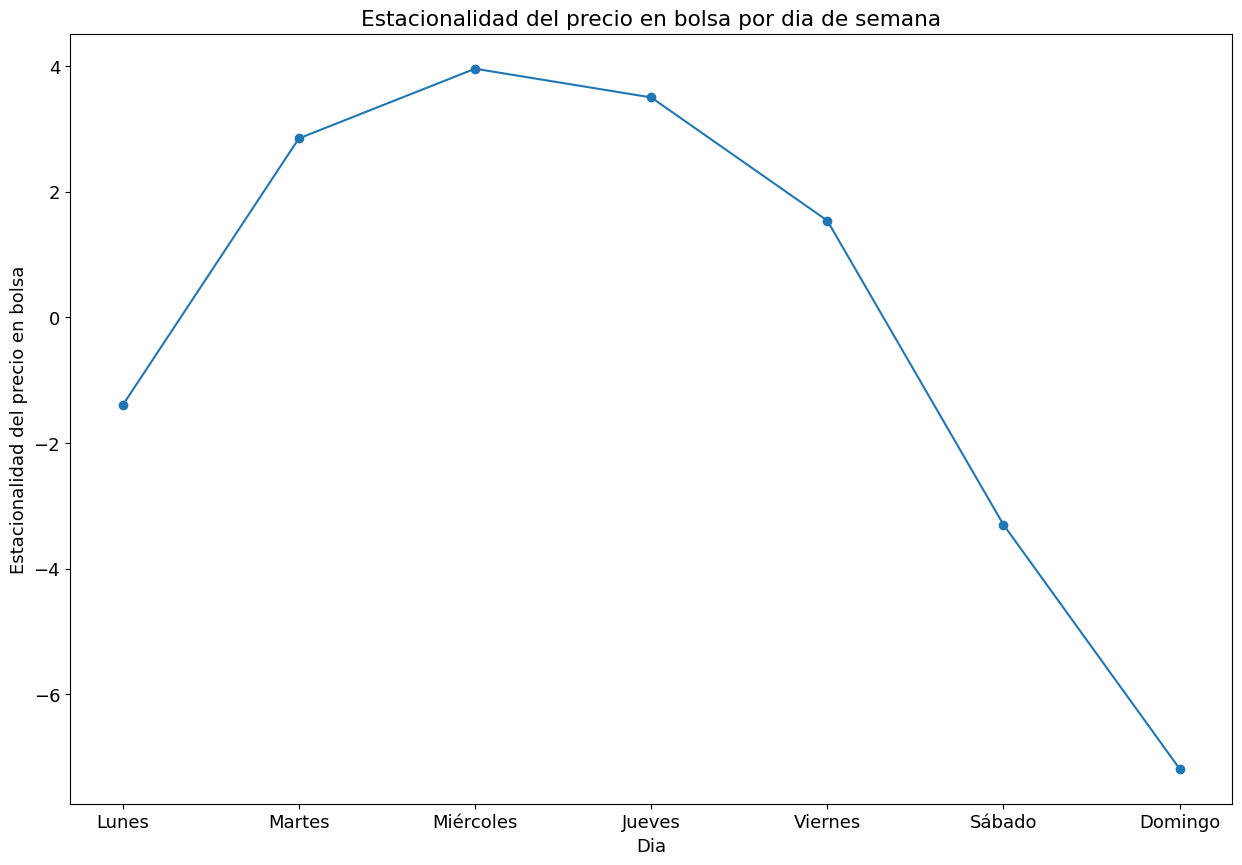

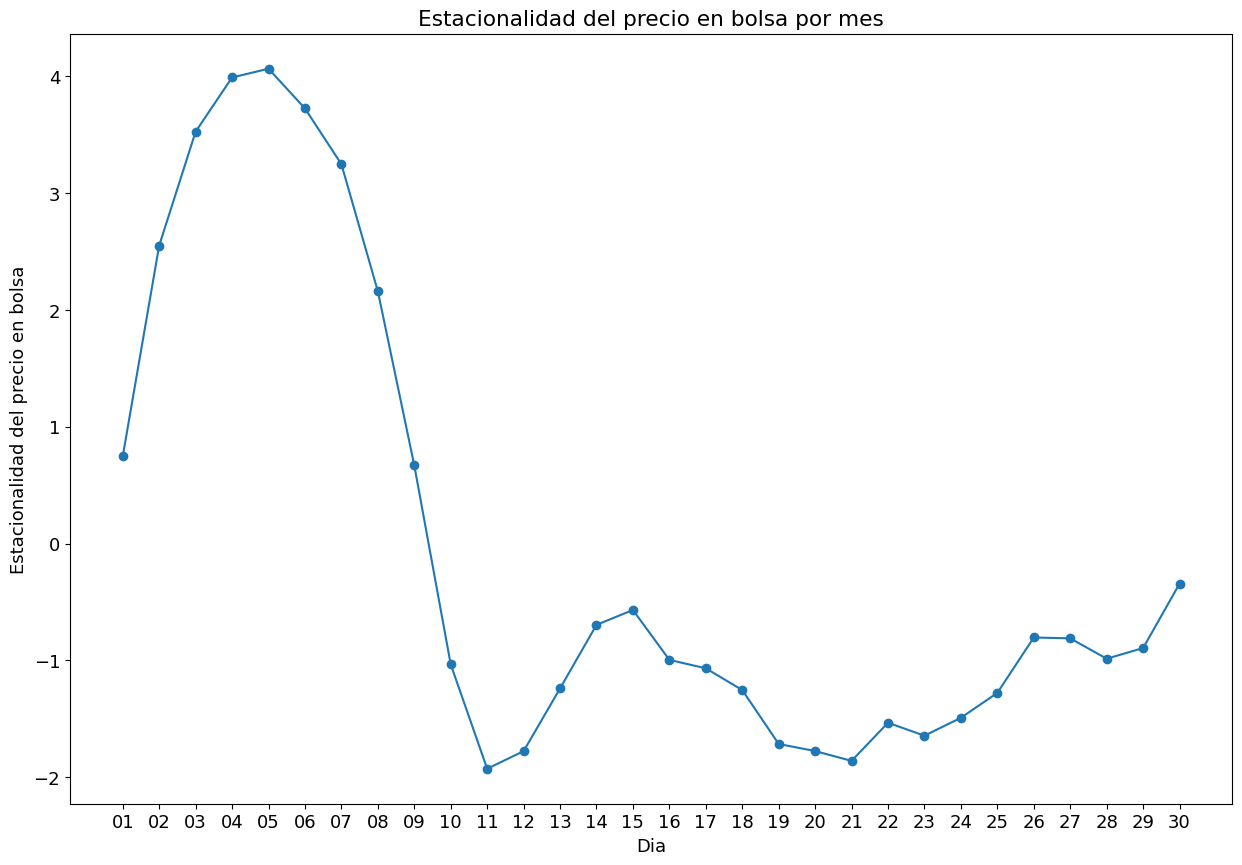

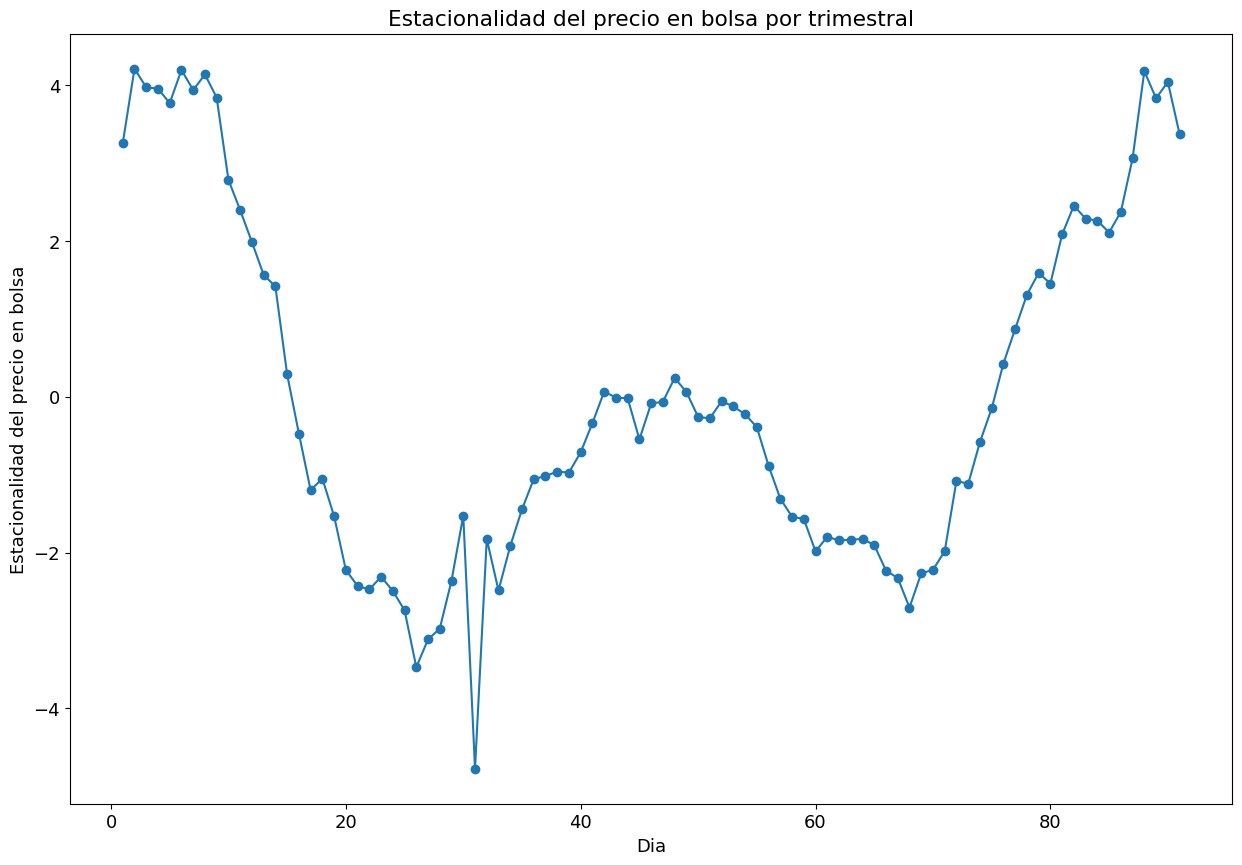

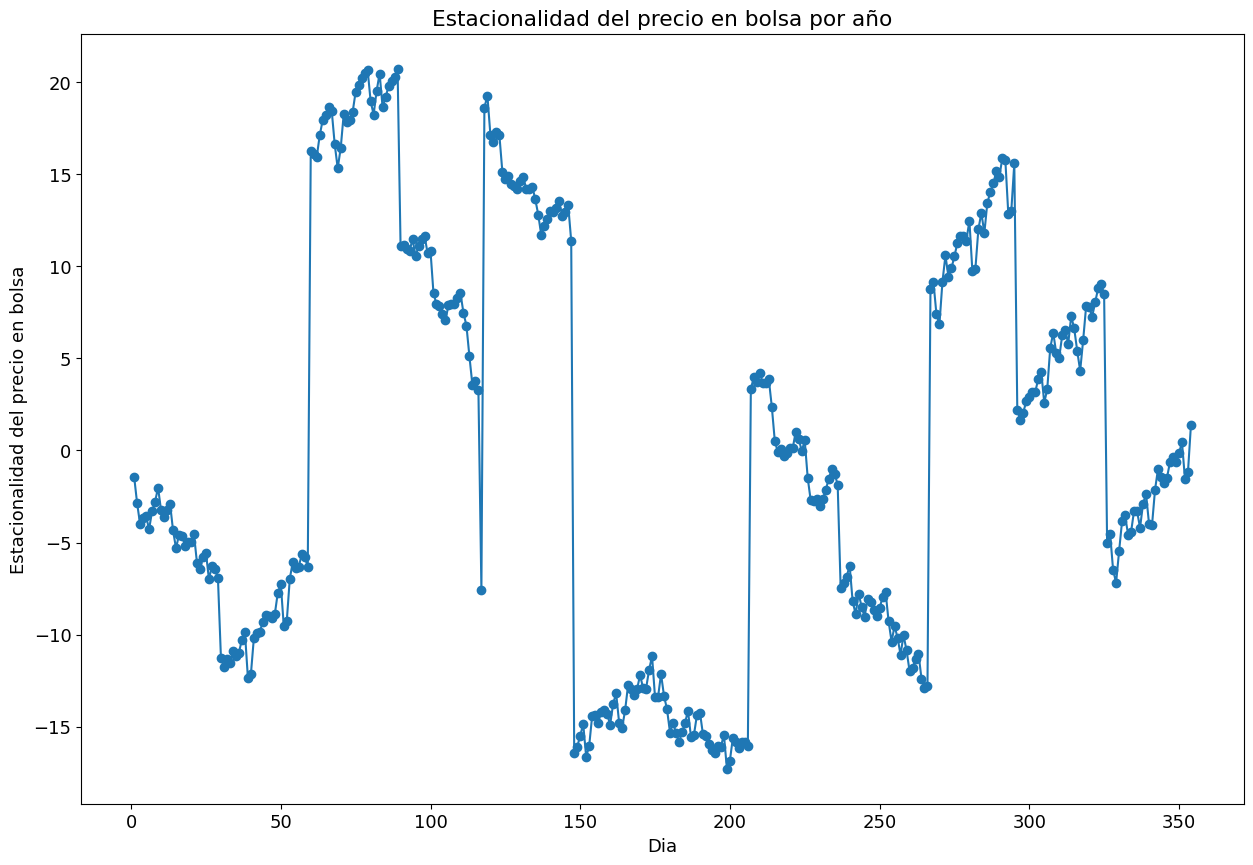

In [91]:
# hacer una grafica distinta para cada una de las estacionalidades, ie. para la estacionalidad semanal hacer el grafico del
# promedio semanal
for vari in [('dia de semana', 'seasonal_7'), ('mes', 'seasonal_30'), ('trimestral', 'seasonal_90'), 
             ('año', 'seasonal_365')]:
    x = df_seasonal.groupby(vari[0])[[vari[1]]].mean().index
    y = df_seasonal.groupby(vari[0])[[vari[1]]].mean().values


    if vari[0] == 'año':
        x = range(1, len(y) + 1)
        

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(x, y, marker='o', linestyle='-')
    ax.set_xlabel('Dia', )
    ax.set_ylabel('Estacionalidad del precio en bolsa')
    ax.set_title(f'Estacionalidad del precio en bolsa por {vari[0]}')

    plt.show()

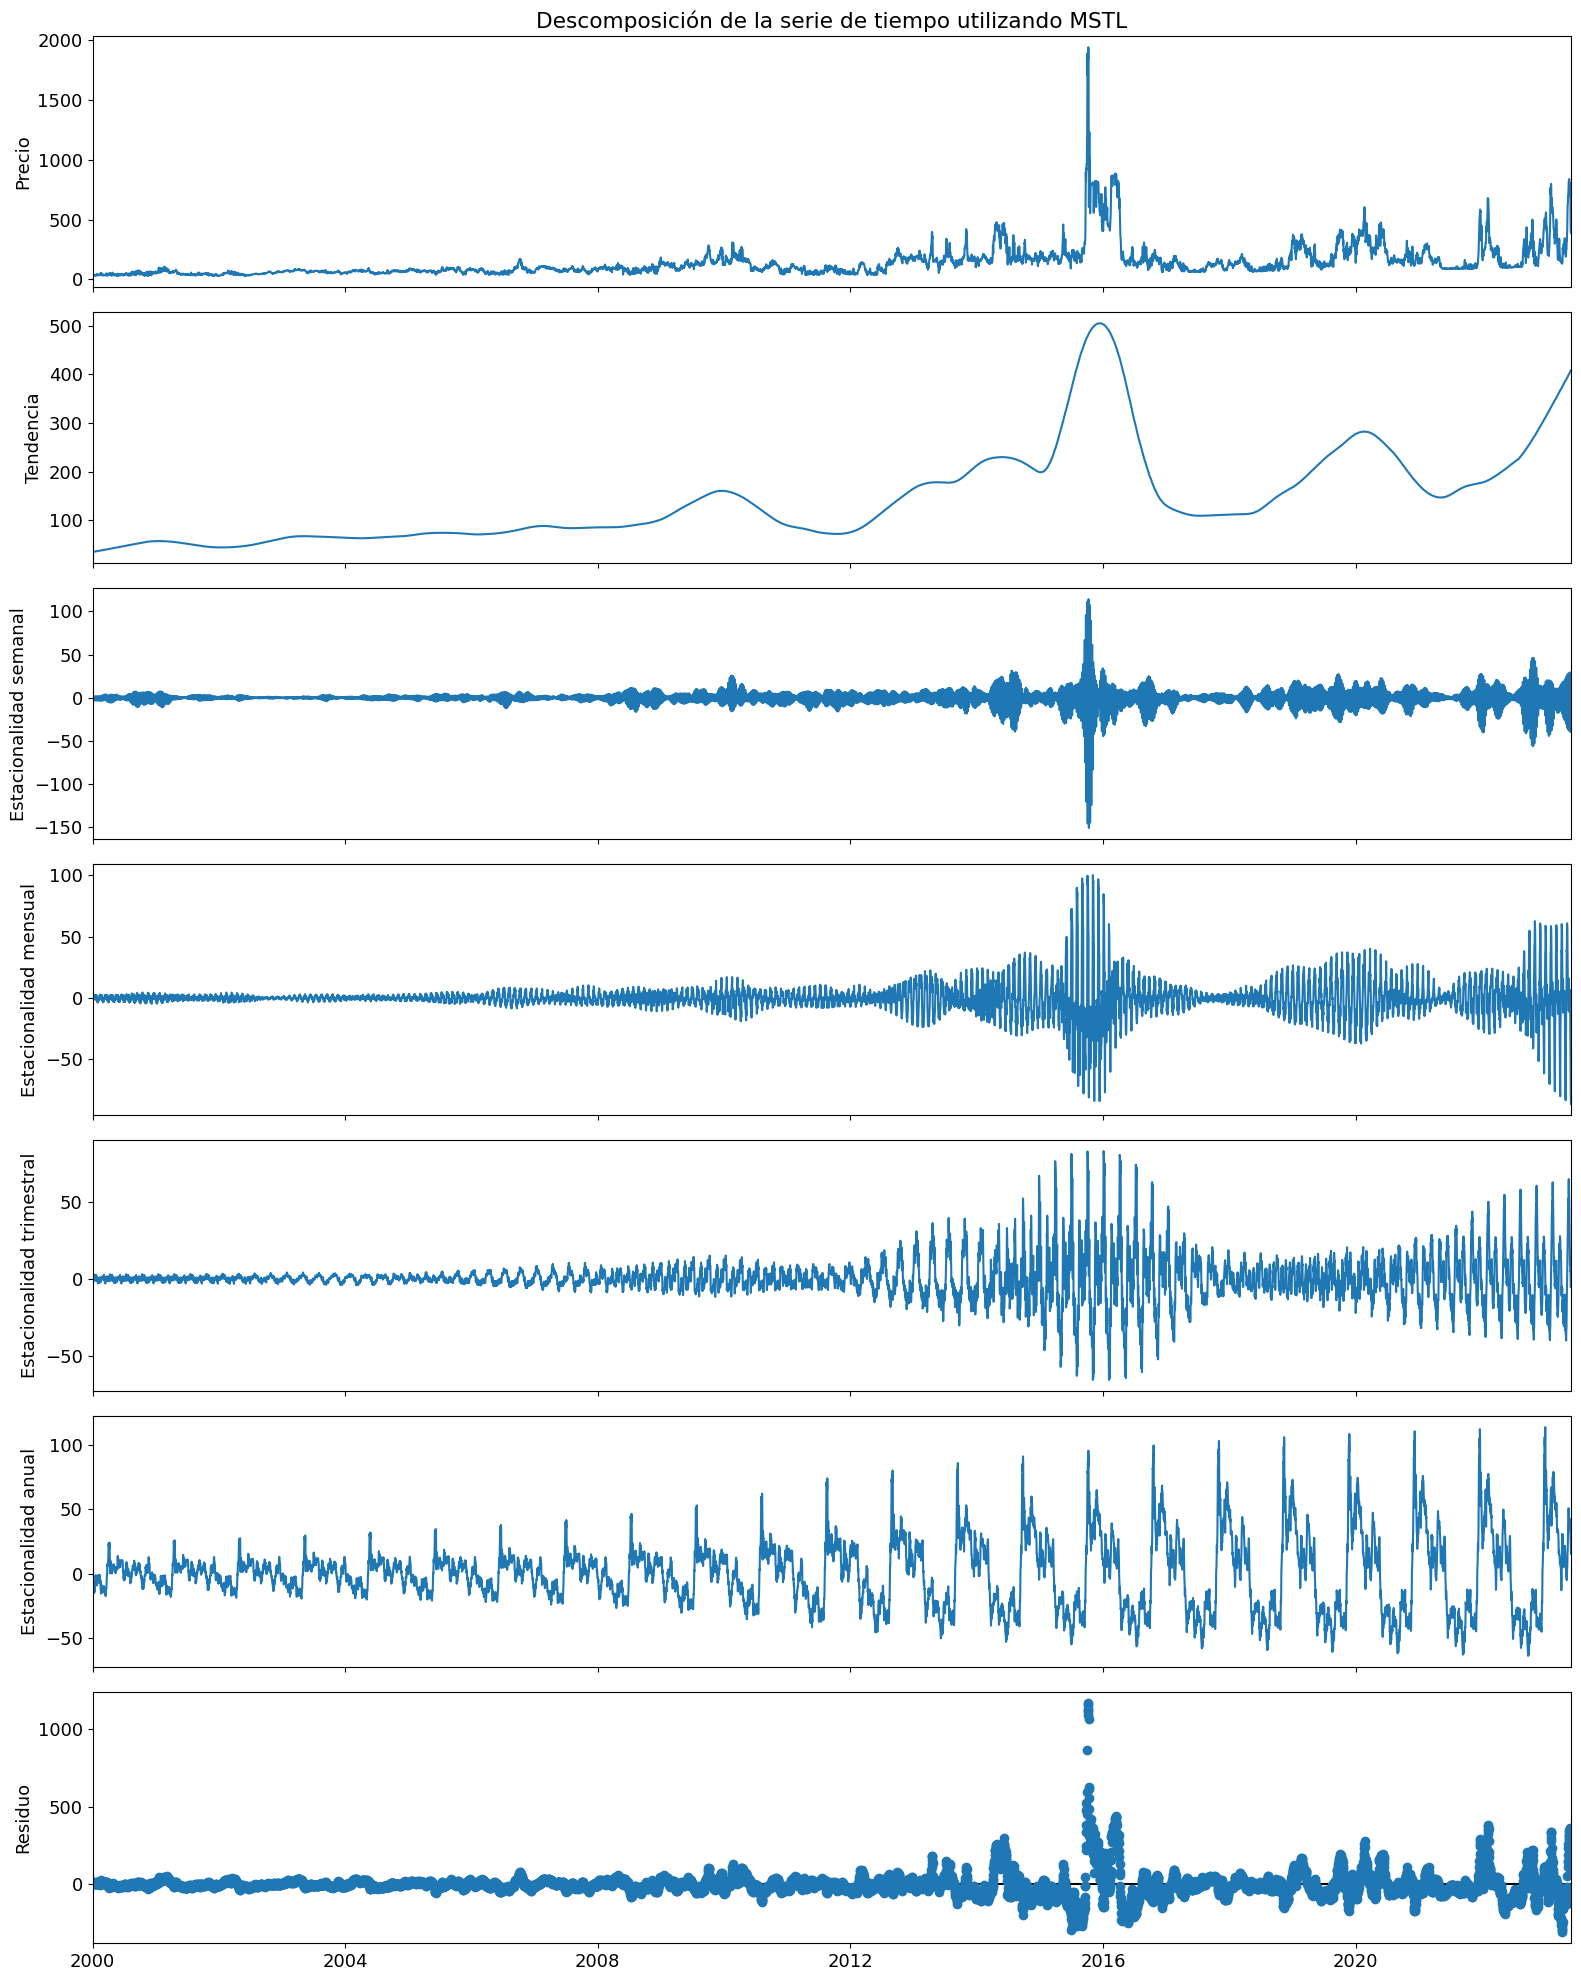

In [48]:
# Descomposición de la serie de tiempo utilizando MSTL
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()
axs = fig.get_axes()
axs[0].set_ylabel("Precio")
axs[0].set_title("Descomposición de la serie de tiempo utilizando MSTL")
axs[1].set_ylabel("Tendencia")
axs[2].set_ylabel("Estacionalidad semanal")
axs[3].set_ylabel("Estacionalidad mensual")
axs[4].set_ylabel("Estacionalidad trimestral")
axs[5].set_ylabel("Estacionalidad anual")
axs[6].set_ylabel("Residuo")
plt.tight_layout()


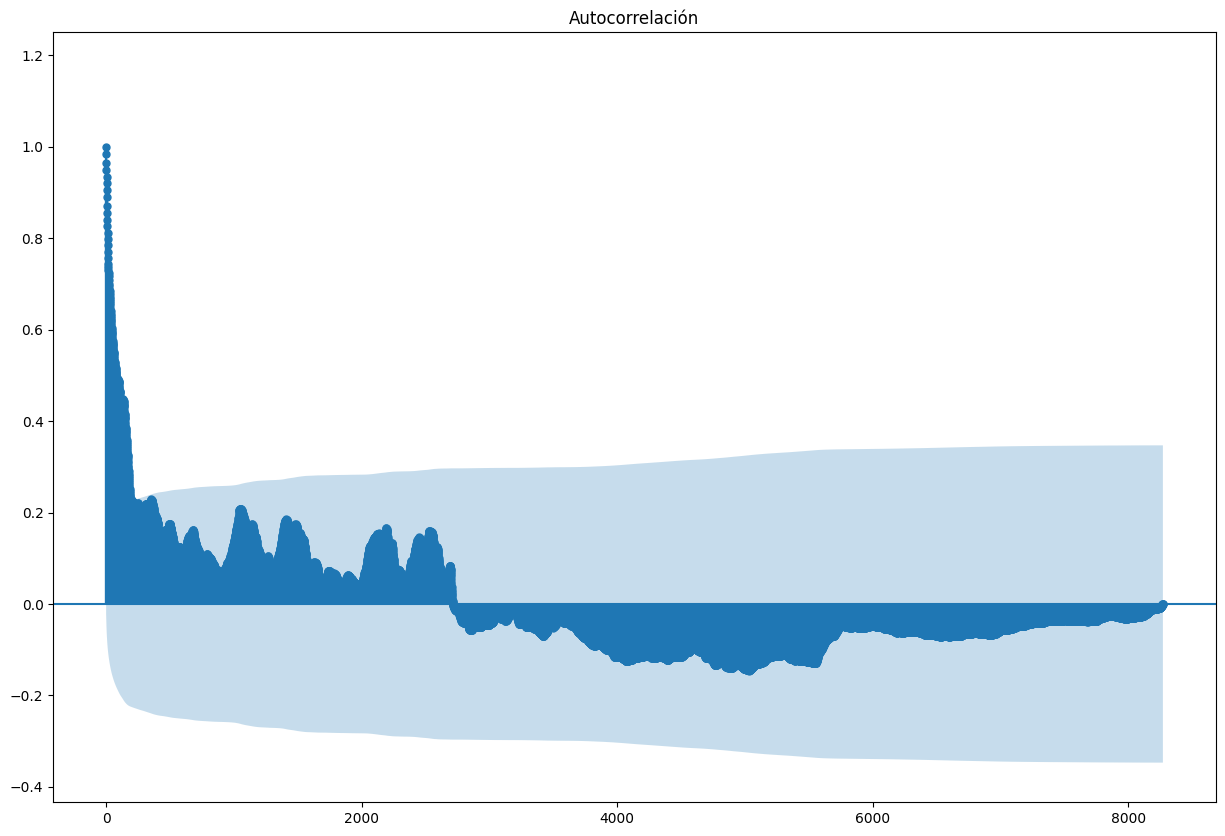

In [52]:
# Visualizando la Autocorrelación y Autocorrelación parcial
# Autocorrelación
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(df_resa_2.values, lags=8270, title='Autocorrelación', auto_ylims=True)
plt.show()

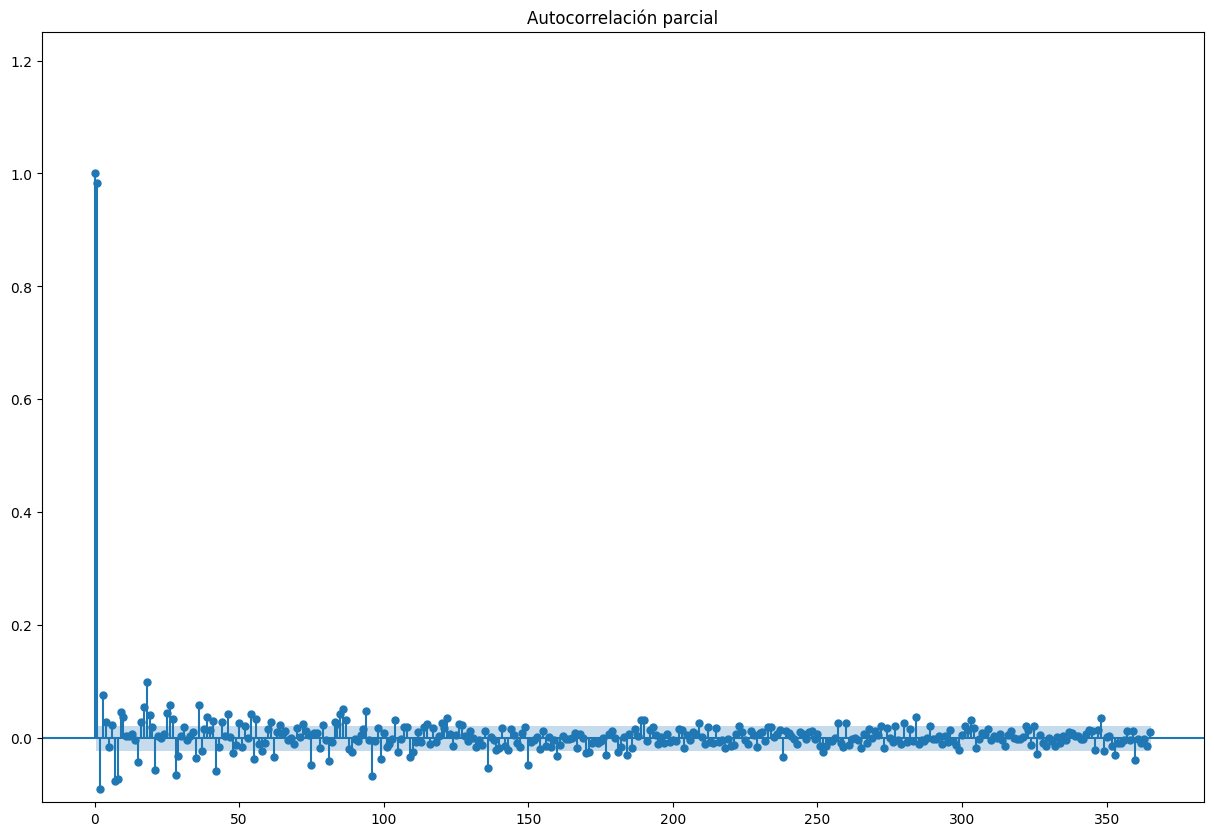

In [53]:
fig = tsaplots.plot_pacf(df_resa_2.values, lags=365, title='Autocorrelación parcial', auto_ylims=True)
plt.show()

Análisis de variables importantes utilizando la libreria tfresh

In [ ]:
df['id'] = 'PrecBolNac'
df['año'] = df['date_hour'].dt.year

In [6]:
df_features = pd.DataFrame()

for year in df['año'].unique():
    df_aux = df[df['año'] == year]
    print(year, end=" ")
    df_aux_fea = tsfresh.extract_features(df_aux, column_id='id', column_sort='date_hour', column_value='price')
    df_aux_fea['año'] = year
    df_features = pd.concat([df_features, df_aux_fea], ignore_index=True)

2000 

Feature Extraction: 100%|██████████| 1/1 [01:09<00:00, 69.89s/it]


2001 

Feature Extraction: 100%|██████████| 1/1 [01:10<00:00, 70.17s/it]


2002 

Feature Extraction: 100%|██████████| 1/1 [01:11<00:00, 71.77s/it]


2003 

Feature Extraction: 100%|██████████| 1/1 [01:05<00:00, 65.97s/it]


2004 

Feature Extraction: 100%|██████████| 1/1 [01:04<00:00, 64.65s/it]


2005 

Feature Extraction: 100%|██████████| 1/1 [01:05<00:00, 65.45s/it]


2006 

Feature Extraction: 100%|██████████| 1/1 [01:04<00:00, 64.56s/it]


2007 

Feature Extraction: 100%|██████████| 1/1 [01:06<00:00, 66.35s/it]


2008 

Feature Extraction: 100%|██████████| 1/1 [01:35<00:00, 95.86s/it]


2009 

Feature Extraction: 100%|██████████| 1/1 [01:06<00:00, 66.26s/it]


2010 

Feature Extraction: 100%|██████████| 1/1 [01:09<00:00, 69.73s/it]


2011 

Feature Extraction: 100%|██████████| 1/1 [01:06<00:00, 66.04s/it]


2012 

Feature Extraction: 100%|██████████| 1/1 [01:06<00:00, 66.04s/it]


2013 

Feature Extraction: 100%|██████████| 1/1 [01:05<00:00, 65.04s/it]


2014 

Feature Extraction: 100%|██████████| 1/1 [01:05<00:00, 65.83s/it]


2015 

Feature Extraction: 100%|██████████| 1/1 [01:04<00:00, 64.79s/it]


2016 

Feature Extraction: 100%|██████████| 1/1 [01:07<00:00, 67.71s/it]


2017 

Feature Extraction: 100%|██████████| 1/1 [01:08<00:00, 68.79s/it]


2018 

Feature Extraction: 100%|██████████| 1/1 [01:10<00:00, 70.01s/it]


2019 

Feature Extraction: 100%|██████████| 1/1 [01:07<00:00, 67.09s/it]


2020 

Feature Extraction: 100%|██████████| 1/1 [01:09<00:00, 69.57s/it]


2021 

Feature Extraction: 100%|██████████| 1/1 [01:02<00:00, 62.53s/it]


2022 

Feature Extraction: 100%|██████████| 1/1 [01:05<00:00, 65.55s/it]


2023 

Feature Extraction: 100%|██████████| 1/1 [00:07<00:00,  7.90s/it]


In [39]:
df_filter = df_features.iloc[:, list(range(38)) + [-1]] # Filtrar las variables que se consideraron mas importantes

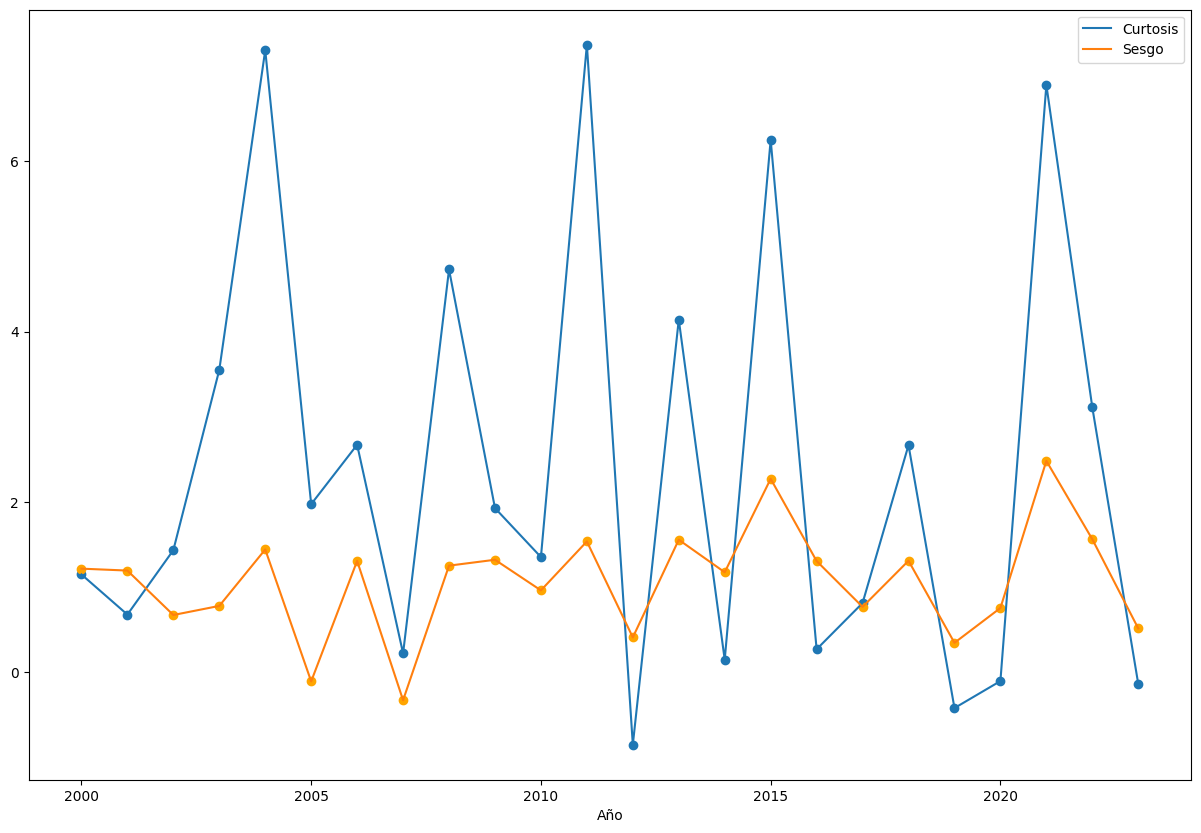

In [41]:
# Grafica de kurtosis y skewness
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df_filter.año, df_filter['price__kurtosis'], label = 'Curtosis')
ax.scatter(df_filter.año, df_filter['price__kurtosis'], marker='o')
ax.plot(df_filter.año, df_filter['price__skewness'], label = 'Sesgo')
ax.scatter(df_filter.año, df_filter['price__skewness'], color='orange', marker='o')

ax.set_xlabel('Año')
ax.legend()

plt.show()

Análisis de pruebas unitarias

In [21]:
# Test de Augmented Dickey Fuller
result = adfuller(df_resa_2.values, regression='ctt')

# Imprimir los resultados
print('PP Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

PP Statistic: -3.210616
p-value: 0.204644
Critical Values:
	1%: -4.415
	5%: -3.855
	10%: -3.567


In [24]:
# Test de Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
result_kpss = kpss(df_resa_2.values, 'c')
print('KPSS Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 1.339679
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\Users\jesus\AppData\Local\Temp\ipykernel_27340\2456434342.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(df_resa_2.values, 'c')


In [6]:
# Revisar las caracteristicas de cada delimitacion de la serie de tiempo
for i in [(0.7,0.2,0.1),(0.8,0.1,0.1),(0.9,0.05,0.05)]:
    total_data = df_data_colum.shape[0]
    train_data = int(total_data * i[0])
    valid_data = int(total_data * i[2])
    print(i[0]*100)
    print("train")
    train = df_data_colum[:train_data]['price']
    print(train.shape)
    print(train.index[-1])
    std_dev = train.std()
    # Calcular el coeficiente de variación
    coefficient_of_variation = (std_dev / train.mean()) * 100
    # Calcular el promedio
    mean_value = train.mean()
    # Calcular el valor máximo
    max_value = train.max()
    # Calcular el valor mínimo
    min_value = train.min()
    # Imprimir los resultados
    print("Desviación estándar:", std_dev)
    print("Coeficiente de variación:", coefficient_of_variation)
    print("Promedio:", mean_value)
    print("Valor máximo:", max_value)
    print("Valor mínimo:", min_value)
    print("")

    print("test")
    test = df_data_colum[train_data + valid_data:]['price']
    print(test.shape)
    print(test.index[0])
    print(test.index[-1])
    std_dev = test.std()
    # Calcular el coeficiente de variación
    coefficient_of_variation = (std_dev / test.mean()) * 100
    # Calcular el promedio
    mean_value = test.mean()
    # Calcular el valor máximo
    max_value = test.max()
    # Calcular el valor mínimo
    min_value = test.min()
    # Imprimir los resultados
    print("Desviación estándar:", std_dev)
    print("Coeficiente de variación:", coefficient_of_variation)
    print("Promedio:", mean_value)
    print("Valor máximo:", max_value)
    print("Valor mínimo:", min_value)
    print("")

    print("vali")
    valid = df_data_colum[train_data:train_data + valid_data]['price']
    print(valid.shape)
    print(valid.index[0])
    print(valid.index[-1])
    std_dev = valid.std()
    # Calcular el coeficiente de variación
    coefficient_of_variation = (std_dev / valid.mean()) * 100
    # Calcular el promedio
    mean_value = valid.mean()
    # Calcular el valor máximo
    max_value = valid.max()
    # Calcular el valor mínimo
    min_value = valid.min()
    # Imprimir los resultados
    print("Desviación estándar:", std_dev)
    print("Coeficiente de variación:", coefficient_of_variation)
    print("Promedio:", mean_value)
    print("Valor máximo:", max_value)
    print("Valor mínimo:", min_value)
    print("")



70.0
train
(138952,)
2016-05-21 15:00:00
Desviación estándar: 146.4581976162745
Coeficiente de variación: 117.46130467077862
Promedio: 124.68633651462375
Valor máximo: 2821.52055
Valor mínimo: 21.53117

test
(39702,)
2018-09-23 18:00:00
2023-05-30 23:00:00
Desviación estándar: 136.2146294985669
Coeficiente de variación: 60.733171879759205
Promedio: 224.28374030628177
Valor máximo: 1035.13068
Valor mínimo: 69.86003

vali
(19850,)
2016-05-21 16:00:00
2018-09-23 17:00:00
Desviación estándar: 49.47284933410754
Coeficiente de variación: 41.159017519073736
Promedio: 120.1992960866499
Valor máximo: 383.45367
Valor mínimo: 60.3121

80.0
train
(158803,)
2018-09-23 18:00:00
Desviación estándar: 138.1187301353919
Coeficiente de variación: 111.27362008294139
Promedio: 124.12531382769845
Valor máximo: 2821.52055
Valor mínimo: 21.53117

test
(19851,)
2021-01-25 21:00:00
2023-05-30 23:00:00
Desviación estándar: 160.668786968066
Coeficiente de variación: 72.5536283142244
Promedio: 221.44831444158984
V

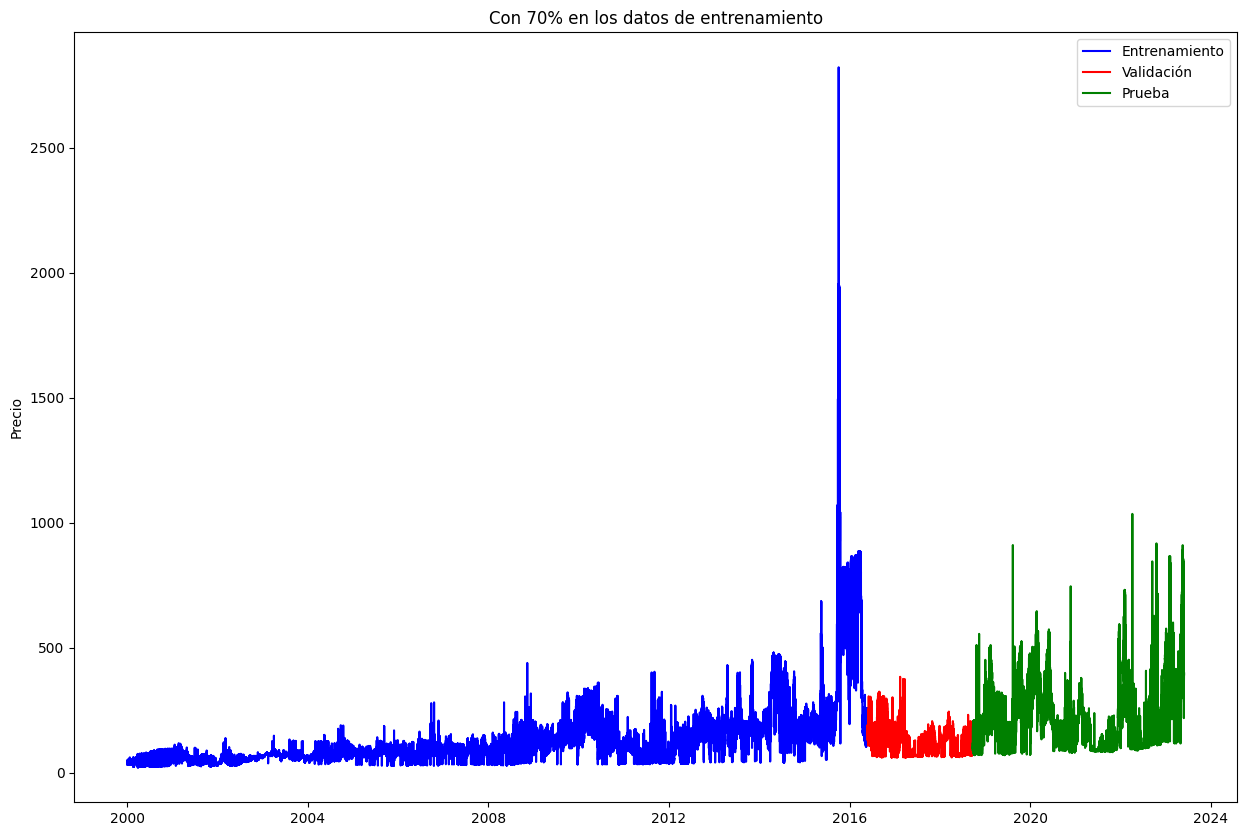

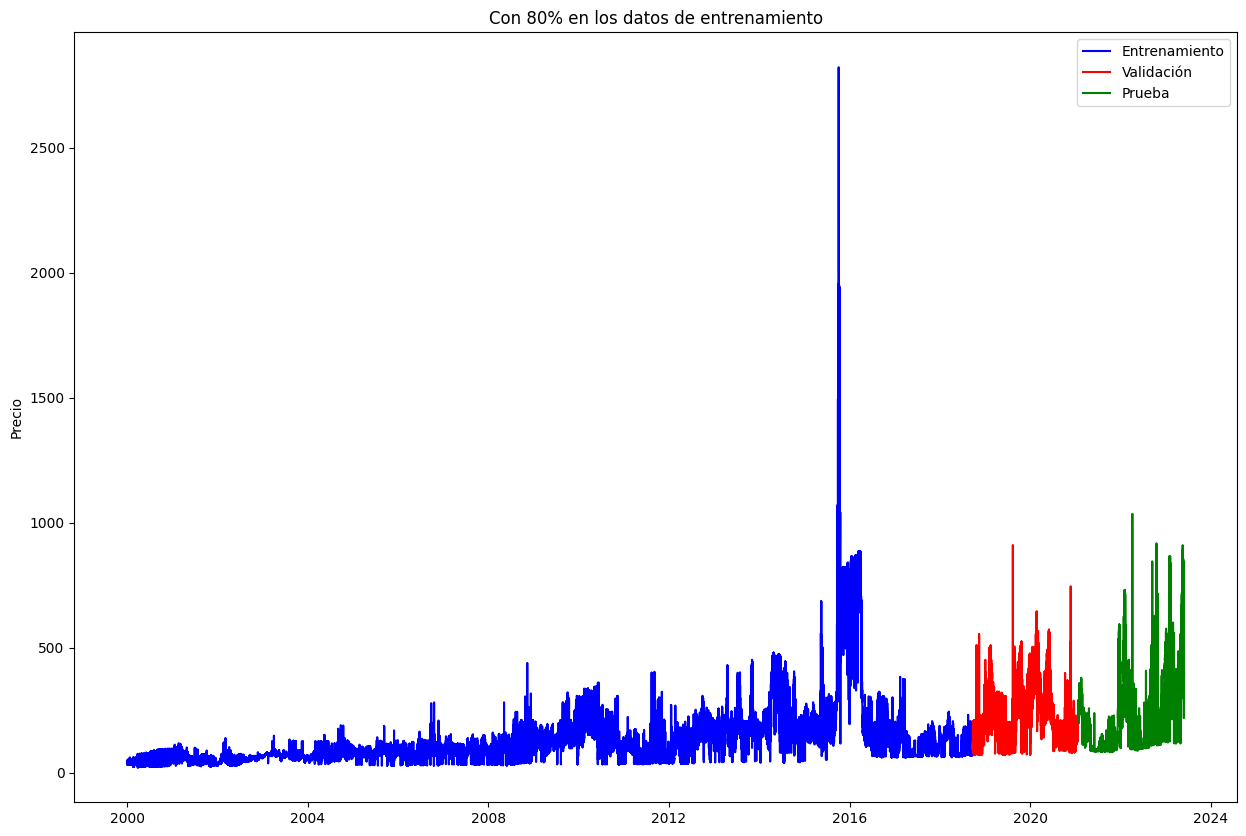

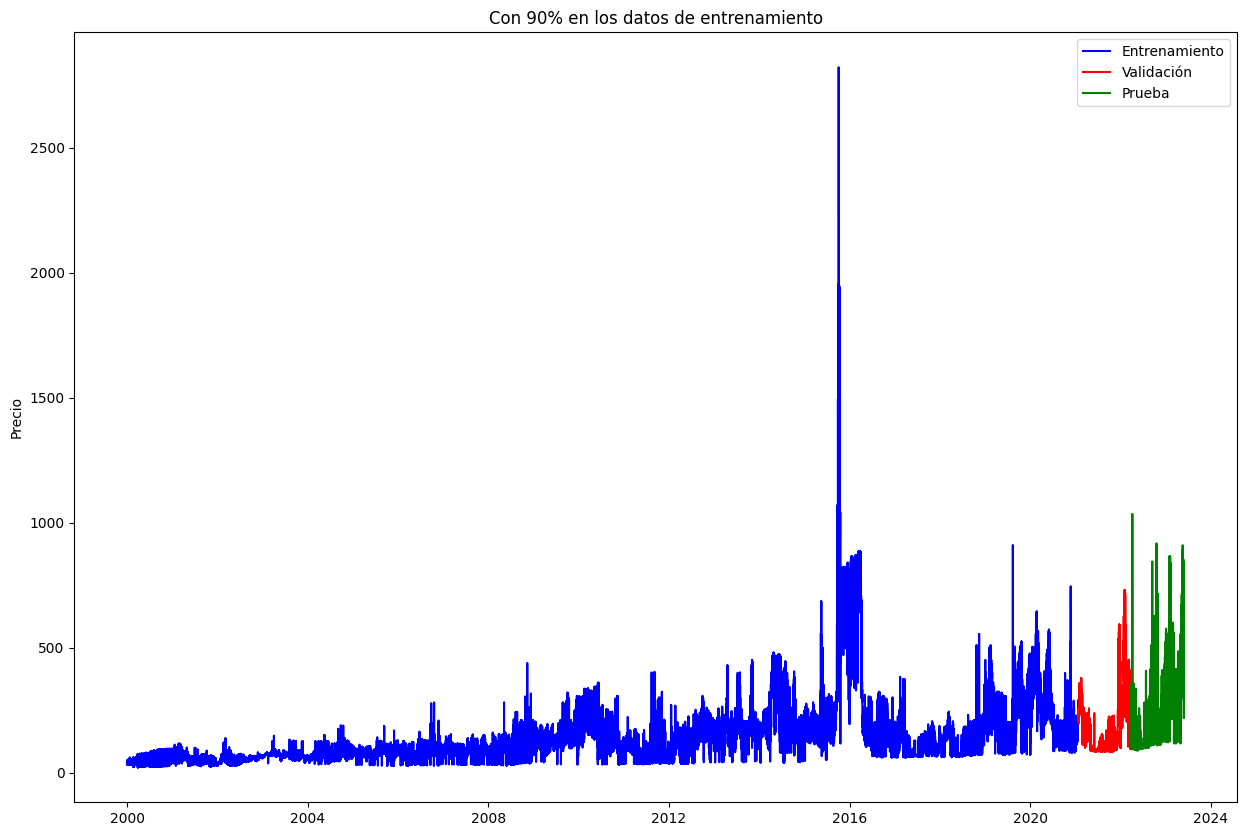

In [15]:
# Delimitación de las series de tiempo
for i in [(0.7,0.2,0.1),(0.8,0.1,0.1),(0.9,0.05,0.05)]:
    total_data = df_data_colum.shape[0]
    train_data = int(total_data * i[0])
    valid_data = int(total_data * i[2])
    train = df_data_colum[:train_data]['price']
    test = df_data_colum[train_data + valid_data:]['price']
    valid = df_data_colum[train_data:train_data + valid_data]['price']
    plt.figure(figsize=(15, 10))
    plt.plot(train.index, train, color='blue', label='Entrenamiento')
    plt.plot(valid.index, valid, color='red', label='Validación')
    plt.plot(test.index, test, color='green', label='Prueba')
    plt.ylabel('Precio')
    plt.title(f'Con {int(i[0]*100)}% en los datos de entrenamiento')
    plt.legend()
    plt.show()
